In [111]:
import psycopg2
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from datetime import datetime

import json
import statistics

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

%matplotlib inline  

In [2]:
with open('config.json') as file:
    config = json.load(file)
    host = config['host']
    database = config['database']
    user = config['user']
    password = config['password']

In [3]:
engine = create_engine(f'postgresql://{user}:{password}@{host}:5432/{database}')

In [64]:
def enumerate_categorical_variables(df, col, new_col_name):
    df2 = df.copy()
    variable_map = {}
    
    for i, value in enumerate(df[col].unique()):
        variable_map[value] = i
        
    df2[new_col_name] = df2.apply(lambda row: variable_map[row[col]], axis=1)
    return df2

def histogram_intersection(h1, h2, bins):
    return np.sum(np.minimum(h1,h2))

def chunk_and_diff(df, col, bins):
    chunk_one = df[df['Rel_Discharge_Day'] <= 3].reset_index(drop=True)
    chunk_two = df[df['Rel_Discharge_Day'] > 3].reset_index(drop=True)
    h1, bins1 = np.histogram(chunk_one[col], bins=bins, weights=[1/len(chunk_one[col])]*len(chunk_one[col]))
    h2, bins2 = np.histogram(chunk_two[col], bins=bins, weights=[1/len(chunk_two[col])]*len(chunk_two[col]))
    return histogram_intersection(h1,h2, bins)

def chunk_and_diff_categorical(df, col, bins):
    col_enum = f"{col}_enum"
    df2 = enumerate_categorical_variables(df, col, col_enum)
    return chunk_and_diff(df2, col_enum, bins)

In [5]:
query = """
SELECT enc."PtID", enc."HospID", enc."Rel_Discharge_Day", demo."Sex", demo."Race1", enc."Payer_Type"
FROM ms_encounters AS enc
INNER JOIN ms_demographicss as demo
ON enc."AdmtID"=demo."AdmtID"
where enc."EncType" = 'I'
"""

demographics = pd.read_sql_query(query, engine)

In [6]:
demographics.head()

,PtID,HospID,Rel_Discharge_Day,Sex,Race1,Payer_Type
0,136345589,27150,1,M,W,MEDICARE - PPS
1,136918267,27100,3,F,W,MANAGED CARE MEDICARE
2,136344460,27150,2,M,W,MEDICAID
3,136354795,31608,4,F,W,MEDICARE - PPS
4,136893443,27300,3,F,W,HMO


In [65]:
chunk_and_diff_categorical(demographics, 'Sex', len(demographics['Sex'].unique()))

0.9179997066046209

In [66]:
chunk_and_diff_categorical(demographics, 'Payer_Type', len(demographics['Payer_Type'].unique()))

0.8333683298441182

In [68]:
chunk_and_diff_categorical(demographics, 'Race1', len(demographics['Race1'].unique()))

0.9757862497721796

In [51]:
query = """
select mv.*, me."Rel_Discharge_Day" from ms_vitals mv
right join ms_encounters me 
on mv."AdmtID" =me."AdmtID" 
where "Vital_Rel_Day" >=0
and me."EncType" = 'I'
"""

vitals_at_admission = pd.read_sql_query(query, engine)

query = """
SELECT * FROM ms_encounters WHERE "EncType"='I'
"""

inpatient_encounters = pd.read_sql_query(query, engine)

def convert_to_datetime(row):
    return datetime.strptime('23:59:59', '%H:%M:%S') if row['Vital_Rpt_Time'] == '?' else datetime.strptime(row['Vital_Rpt_Time'], '%H:%M:%S')

vitals_at_admission['Vital_datetime'] = vitals_at_admission.apply(lambda row: convert_to_datetime(row), axis=1)

vitals_at_admission.sort_values(['Vital_Rel_Day', 'Vital_datetime'], inplace=True)

inpatient_admission_ids = inpatient_encounters['AdmtID']
vitals_for_inpatient_stays = vitals_at_admission[vitals_at_admission['AdmtID'].isin(inpatient_admission_ids)]
groupby_admissions = vitals_for_inpatient_stays.groupby('AdmtID')

In [52]:
vitals_dict = {}

def get_mean_of_continuous_variable(df, code, num_recent = 3):
    matched_code = df[df['Source_System_Original_Code'] == code]
    n_most_recent = matched_code.tail(num_recent)
    mean = n_most_recent['Vital_Result_Value_Txt'].astype(float).mean()
    return mean

def split_blood_pressure(blood_pressures):
    systolics = []
    diastolics = []
    for blood_pressure in blood_pressures:
        if blood_pressure is None:
            continue
        split = blood_pressure.split('/')
        systolics.append(int(split[0]))
        diastolics.append(int(split[1]))
    return (systolics, diastolics)

for name, group in groupby_admissions:
    blood_pressures = group[group['Vital_Id_Txt'] == 'Blood pressure:']['Vital_Result_Value_Txt'].reset_index(drop=True)

    systolic, diastolic = split_blood_pressure(blood_pressures)
    
    temperature_c = group[group['Source_System_Original_Code'] == 'K33010002A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    temperature_f = group[group['Source_System_Original_Code'] == 'K33010003A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    temperature_f_to_c = temperature_f.apply(lambda f: (f - 32) * (5/9))
    temperature_c.append(temperature_f_to_c)
    
    weight_kg = group[group['Source_System_Original_Code'] == 'K31010003A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    weight_lb = group[group['Source_System_Original_Code'] == 'K31010001A']['Vital_Result_Value_Txt'].reset_index(drop=True).astype(float)
    weight_lb_to_kg = weight_lb.apply(lambda lb: lb / 2.205)
    weight_kg.append(weight_lb_to_kg)
    
    
    vitals_dict[name] = {
        "mean_pulse": get_mean_of_continuous_variable(group, 'K33010006A'),
        "mean_oxygen_levels": get_mean_of_continuous_variable(group, 'L35010001A'),
        "mean_temperature_c": temperature_c.mean(),
        "mean_weight_kg": weight_kg.mean(),
        "systolic_blood_pressure": -1 if len(systolic) == 0 else statistics.mean(systolic[-3:]),
        "diastolic_blood_pressure": -1 if len(diastolic) == 0 else statistics.mean(diastolic[-3:]),
        "Rel_Discharge_Day": group['Rel_Discharge_Day'].reset_index(drop=True)[0]
    }

In [53]:
aggregated_vitals = pd.DataFrame(vitals_dict).T.reset_index().rename(index=int, columns={'index': 'AdmtID'})
aggregated_vitals.fillna(-1, inplace=True)

In [54]:
chunk_and_diff(aggregated_vitals, 'mean_pulse', 50)

0.7076458099814347

In [56]:
chunk_and_diff(aggregated_vitals, 'mean_oxygen_levels', 50)

0.9982187388671179

In [60]:
chunk_and_diff(aggregated_vitals, 'mean_temperature_c', 50)

0.9955787071230171

In [61]:
chunk_and_diff(aggregated_vitals, 'mean_weight_kg', 50)

0.49711462956327856

In [62]:
chunk_and_diff(aggregated_vitals, 'systolic_blood_pressure', 50)

0.19449795610720455

In [63]:
chunk_and_diff(aggregated_vitals, 'diastolic_blood_pressure', 50)

0.12496232602888369

In [86]:
def sort_and_rank_features(df, columns, bins, categorical=False):
    if categorical:
        pass;
    scores = {}
    
    for column in columns:
        scores[column] = chunk_and_diff(df, column, 50)
    
    scores_df = pd.Series(scores, name='Score')
    scores_df.index.name = 'Feature'
    scores_df = scores_df.reset_index()
    
    return scores_df.sort_values('Score', ascending=False).reset_index(drop=True)
    

In [88]:
vital_scores = sort_and_rank_features(aggregated_vitals, list(aggregated_vitals.columns[1:-1]), 50)
vital_scores

,Feature,Score
0,diastolic_blood_pressure,0.875038
1,systolic_blood_pressure,0.805502
2,mean_weight_kg,0.502885
3,mean_pulse,0.292354
4,mean_temperature_c,0.004421
5,mean_oxygen_levels,0.001781


In [89]:
query = """
select *, me."Rel_Discharge_Day" 
from ms_inpatient_pharm mip 
inner join ms_encounters me 
on mip."AdmtID" = me."AdmtID" 
where mip."Rel_Admin_Date" <= 0
"""

meds = pd.read_sql_query(query, engine)

In [90]:
top_50_meds = meds["Med"].value_counts()[:50]

In [96]:
def mark_med(row, med):
    if row['Med'] == med:
        return 1
    else:
        return 0
    
meds_df = meds[["Rel_Discharge_Day"]]
meds_df = meds_df.loc[:,~meds_df.columns.duplicated()]

for med, i in top_50_meds.iteritems():
    label = f"received_{med}"
    meds_df[label] = meds.apply(lambda row: mark_med(row,  med), axis=1)
    print(i)

meds_df.head()

10938
8518
6970
5678
5548
5443
4775
4059
3040
3024
3021
2943
2483
2361
2231
2109
2026
2018
1850
1798
1774
1760
1641
1640
1633
1400
1321
1317
1307
1270
1250
1250
1154
1118
1066
1065
1035
916
914
896
845
828
825
825
824
823
808
804
803
789


,Rel_Discharge_Day,received_DILAUDID,received_SUBLIMAZE,received_ZOFRAN,received_?,received_VERSED,received_LACTATED RINGERS,received_ROXICODONE,received_TylenoL,received_NACL-0.9%,...,received_ROCEPHIN,received_ISOVUE-370,received_LOPRESSOR,received_MORPHINE SULFATE,received_MOTRIN,received_APRESOLINE,received_ROXICODONE 5 MG IR TAB,received_LACTATED RINGERS SOLN 1000 ML,received_PERCOCET 5/325 MG,"received_PERCOCET, ROXICET"
0,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [104]:
med_scores = sort_and_rank_features(meds_df, list(meds_df.columns[1:]), 2)
med_scores

,Feature,Score
0,received_LACTATED RINGERS SOLN 1000 ML,0.999867
1,received_ISOVUE-370,0.999622
2,received_ROXICODONE 5 MG IR TAB,0.999571
3,received_APRESOLINE,0.999524
4,received_PEPCID,0.999512
5,received_NORCO 5/325,0.999420
6,received_ZOFRAN ODT,0.999253
7,received_HEPARIN,0.999162
8,received_FENTANYL,0.998937
9,received_LIPITOR,0.998922


In [98]:
query = """
select mp."PX_Desc", me."Rel_Discharge_Day"
from ms_procedures mp 
inner join ms_encounters me 
on mp."AdmtID" = me."AdmtID" 
where mp."Rel_Service_Day" <= 0
"""

procedures = pd.read_sql_query(query, engine)
px_df = procedures[["Rel_Discharge_Day"]]

In [101]:


def mark_procedure(row, procedure):
    if row['PX_Desc'] == procedure:
        return 1
    else:
        return 0
    
px_df = procedures[["Rel_Discharge_Day"]]
px_df = px_df.loc[:,~px_df.columns.duplicated()]

for px, i in procedures["PX_Desc"].value_counts()[:50].iteritems():
    label = f"received_{px}"
    px_df[label] = procedures.apply(lambda row: mark_procedure(row,  px), axis=1)
    print(i)

17299
16732
15330
14058
11728
11602
11141
10715
10693
9469
8288
7264
7041
6697
6087
5653
5434
5432
5366
5336
4509
4472
4458
4421
4241
4143
3556
3541
3461
3104
2921
2847
2815
2780
2757
2469
2395
2278
2202
2169
2026
2001
1973
1844
1719
1688
1662
1652
1562
1536


In [103]:
px_scores = sort_and_rank_features(px_df, list(px_df.columns[1:]), 2)
px_scores

,Feature,Score
0,received_Morphine sulfate injection,0.999960
1,received_ROUTINE VENIPUNCTURE,0.999661
2,received_HEMOGLOBIN,0.999369
3,"received_Locm 300-399mg/ml iodine,1ml",0.999128
4,received_Inj heparin sodium per 1000u,0.998836
5,received_RBC ANTIBODY SCREEN,0.998715
6,received_FLUOROSCOPY <1 HR PHYS/QHP,0.998638
7,received_BLOOD TYPING SEROLOGIC RH(D),0.998511
8,received_Promethazine hcl injection,0.998503
9,received_BLOOD TYPING SEROLOGIC ABO,0.998493


In [118]:
X = aggregated_vitals[aggregated_vitals.columns[1:-1]]
y = aggregated_vitals['Rel_Discharge_Day']

In [122]:
vitals_rf = RandomForestRegressor(n_estimators=100)
vitals_rf.fit(X, y)

RandomForestRegressor()

In [123]:
vitals_rf.feature_importances_

array([0.23441037, 0.10167685, 0.14345919, 0.22698004, 0.19562683,
       0.09784671])

<BarContainer object of 6 artists>

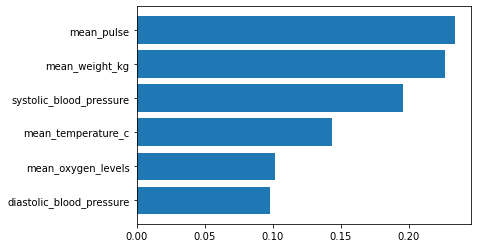

In [125]:
sorted_features = vitals_rf.feature_importances_.argsort()
plt.barh(aggregated_vitals.columns[1:-1][sorted_features], vitals_rf.feature_importances_[sorted_features])

In [117]:
aggregated_vitals.columns[1:-1]

Index(['mean_pulse', 'mean_oxygen_levels', 'mean_temperature_c',
       'mean_weight_kg', 'systolic_blood_pressure',
       'diastolic_blood_pressure'],
      dtype='object')

In [128]:
X_px = px_df[px_df.columns[1:]]
y_px = px_df['Rel_Discharge_Day']

In [129]:
px_rf = RandomForestRegressor()
px_rf.fit(X_px, y_px)

RandomForestRegressor()

<BarContainer object of 50 artists>

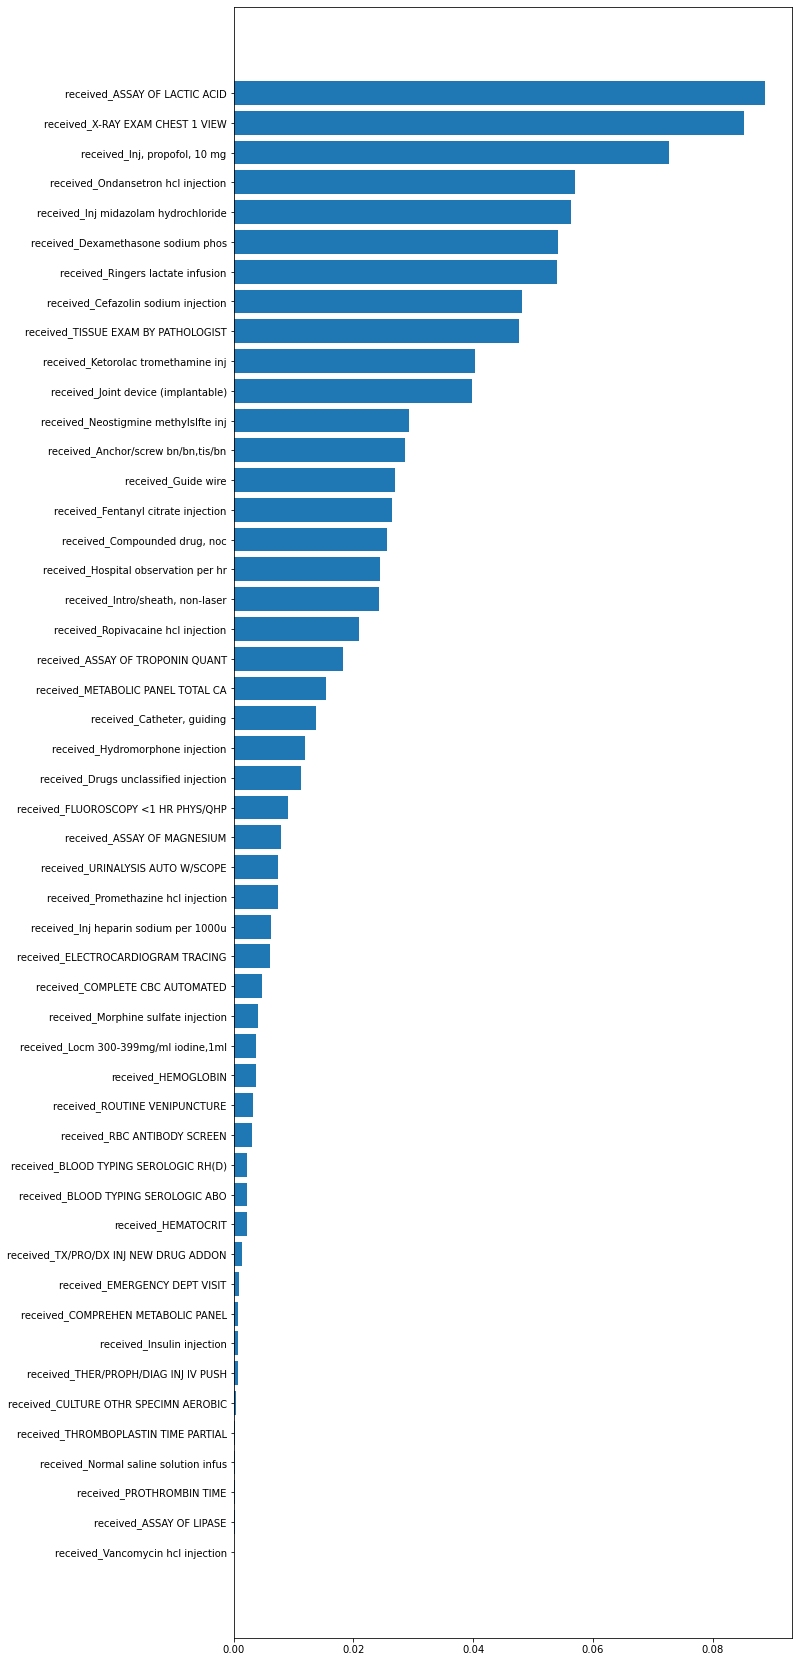

In [138]:
px_sorted_features = px_rf.feature_importances_.argsort()

plt.figure(figsize=(10,30))
plt.barh(px_df.columns[1:][px_sorted_features], px_rf.feature_importances_[px_sorted_features])

In [139]:
rx_X = meds_df[meds_df.columns[1:]]
rx_y = meds_df['Rel_Discharge_Day']

In [140]:
rx_rf = RandomForestRegressor()
rx_rf.fit(rx_X, rx_y)

RandomForestRegressor()

<BarContainer object of 50 artists>

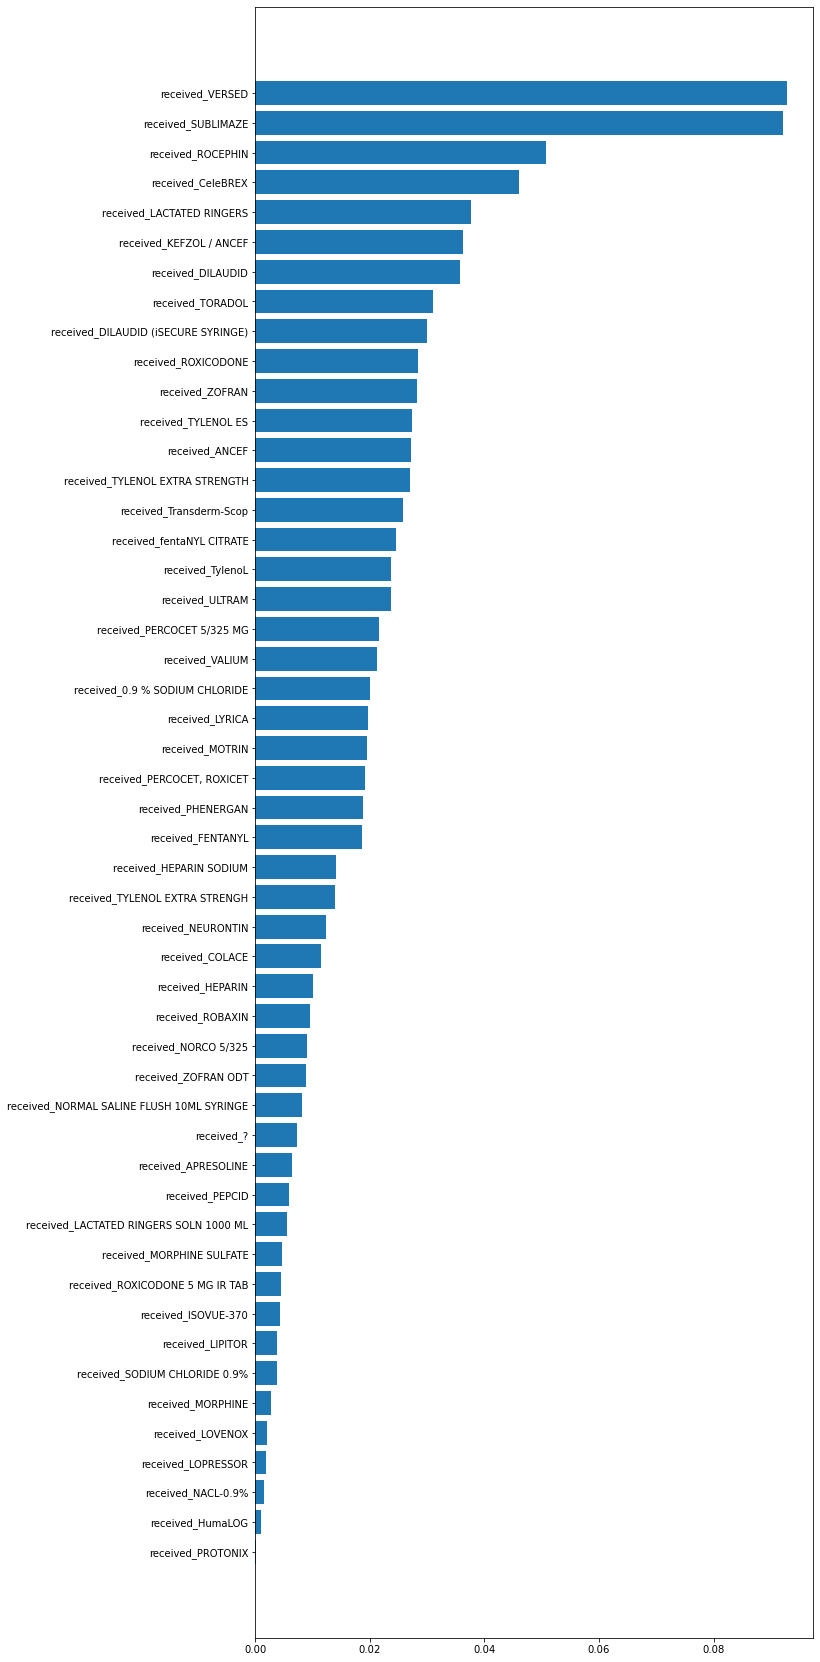

In [141]:
rx_sorted_features = rx_rf.feature_importances_.argsort()

plt.figure(figsize=(10,30))
plt.barh(meds_df.columns[1:][rx_sorted_features], rx_rf.feature_importances_[rx_sorted_features])

In [146]:
aggregated_vitals['discharge_under_median'] = aggregated_vitals.apply(lambda row : 1 if row['Rel_Discharge_Day'] <= 3 else 0, axis=1)

In [147]:
aggregated_vitals

,AdmtID,mean_pulse,mean_oxygen_levels,mean_temperature_c,mean_weight_kg,systolic_blood_pressure,diastolic_blood_pressure,Rel_Discharge_Day,discharge_under_median
0,172480817323018509,75.333333,94.666667,36.443750,-1.00,97.333333,56.333333,2.0,1
1,181550818221412364,98.000000,95.666667,36.825000,29.30,108.666667,70.333333,1.0,1
2,181799000166943661,79.000000,90.666667,36.640000,95.40,135.333333,76.000000,1.0,1
3,181799000203983706,69.333333,99.000000,36.575000,-1.00,99.666667,52.333333,3.0,1
4,181799000215963959,72.666667,94.666667,36.142857,-1.00,119.333333,72.000000,3.0,1
...,...,...,...,...,...,...,...,...,...
9791,193659000219922332,69.333333,95.666667,36.614286,-1.00,93.666667,57.666667,3.0,1
9792,193659000219954861,72.666667,95.666667,36.476923,-1.00,124.000000,69.666667,6.0,0
9793,193659000240927091,91.000000,98.666667,36.812500,61.45,118.666667,75.333333,1.0,1
9794,193659000245930062,59.666667,96.333333,36.440000,-1.00,120.333333,64.666667,3.0,1


<BarContainer object of 6 artists>

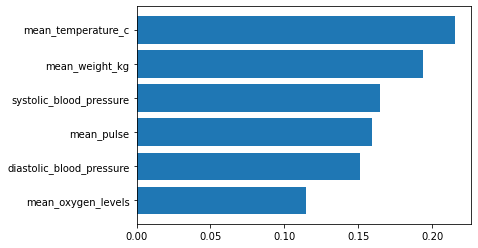

In [148]:
X = aggregated_vitals[aggregated_vitals.columns[1:-2]]
y = aggregated_vitals['discharge_under_median']

vitals_rf = RandomForestRegressor(n_estimators=100)
vitals_rf.fit(X, y)

sorted_features = vitals_rf.feature_importances_.argsort()
plt.barh(aggregated_vitals.columns[1:-2][sorted_features], vitals_rf.feature_importances_[sorted_features])

In [149]:
px_df['discharge_under_median'] = px_df.apply(lambda row : 1 if row['Rel_Discharge_Day'] <= 3 else 0, axis=1)

<BarContainer object of 50 artists>

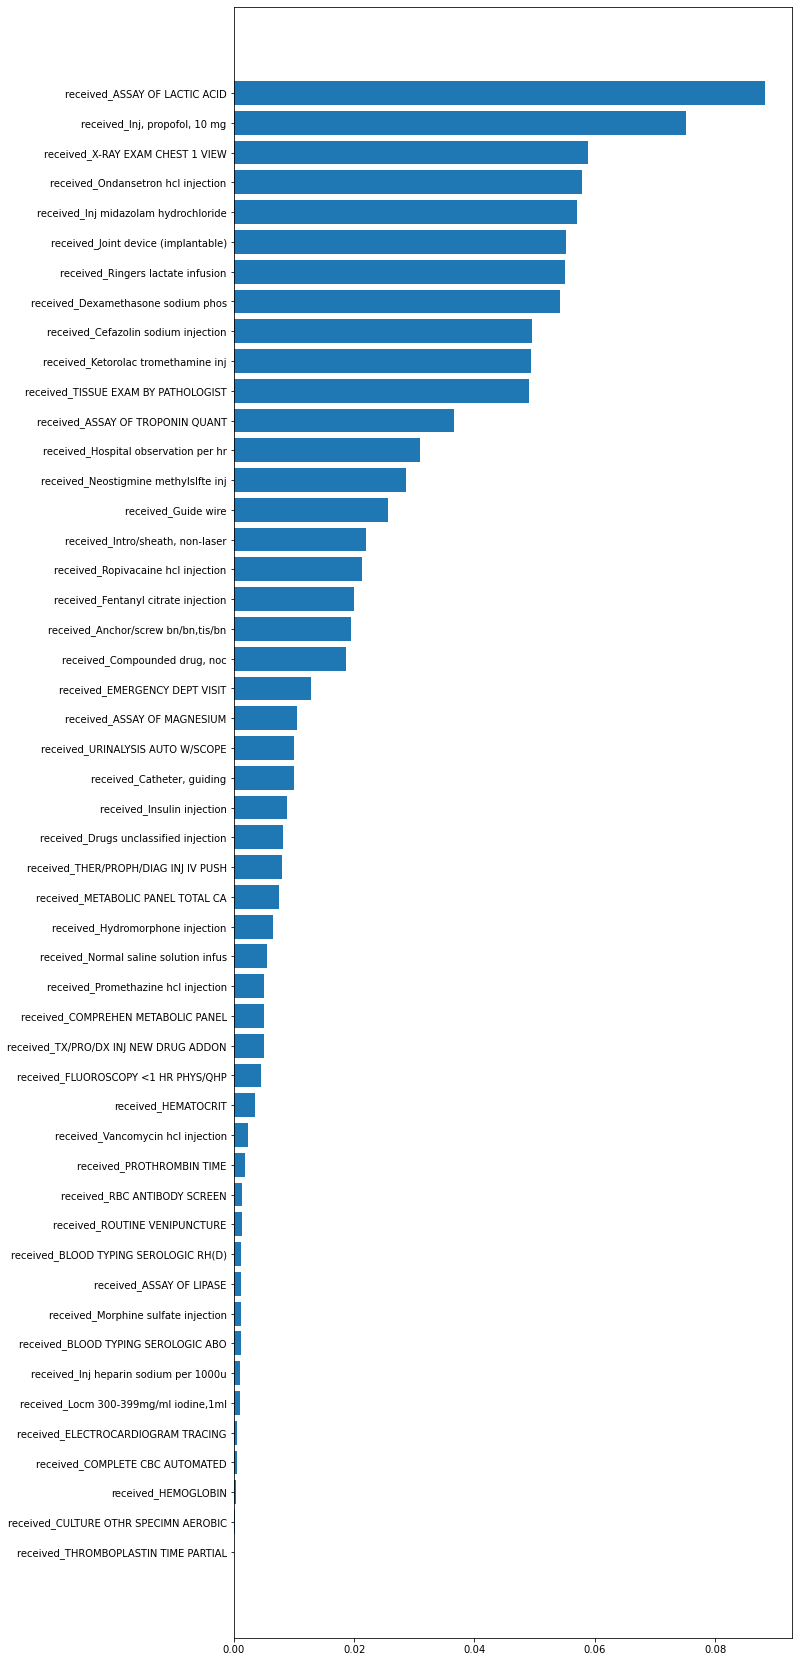

In [152]:
X = px_df[px_df.columns[1:-1]]
y = px_df['discharge_under_median']

px_rf = RandomForestRegressor(n_estimators=100)
px_rf.fit(X, y)

plt.figure(figsize=(10,30))

sorted_features = px_rf.feature_importances_.argsort()
plt.barh(px_df.columns[1:-1][sorted_features], px_rf.feature_importances_[sorted_features])

<BarContainer object of 50 artists>

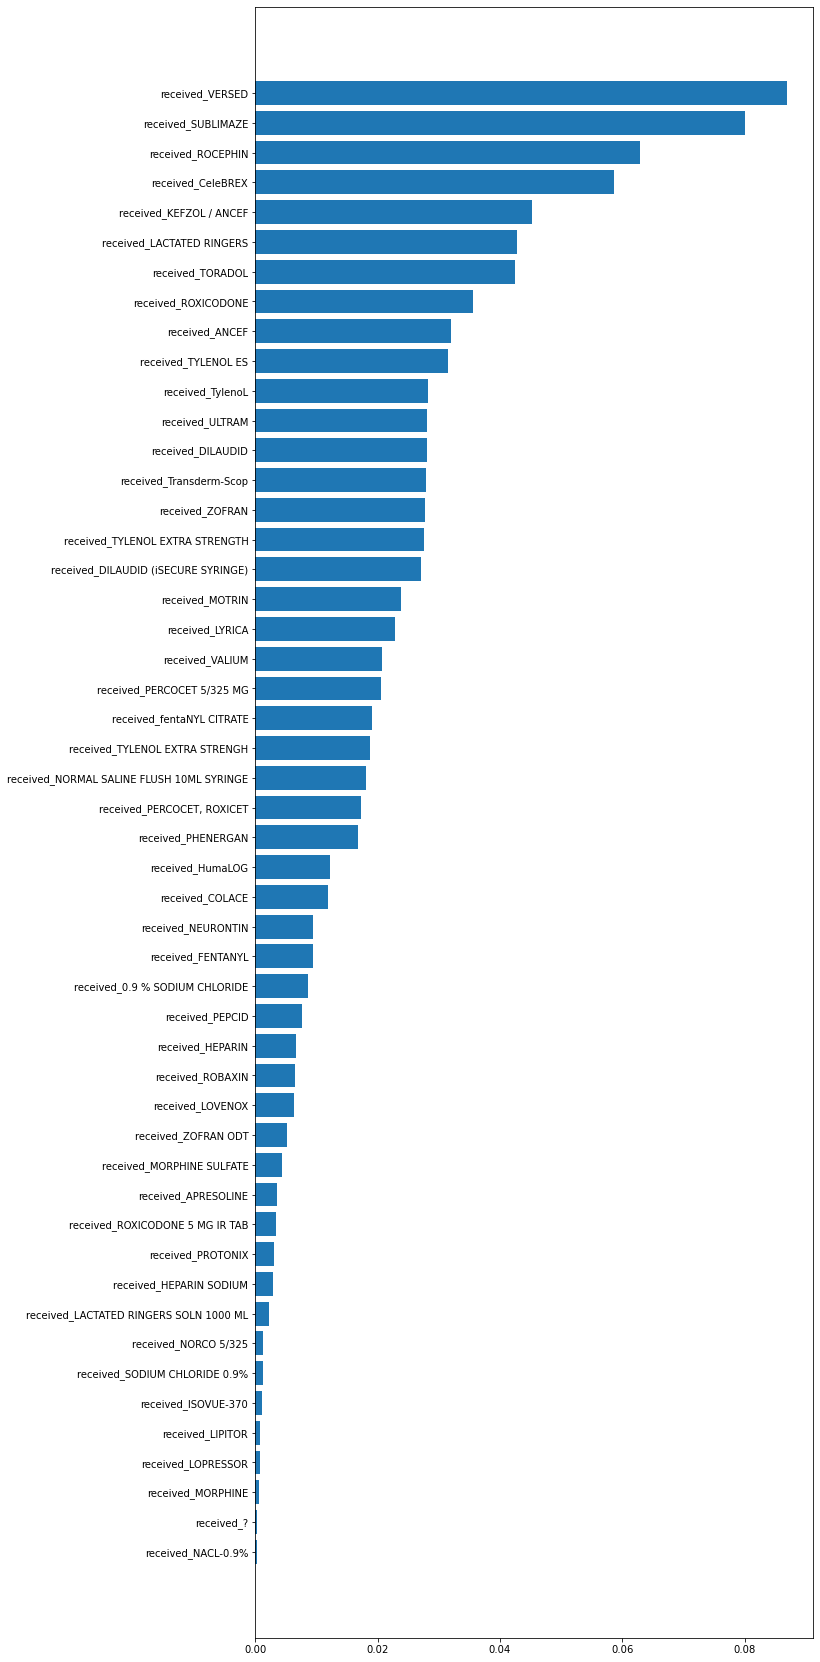

In [153]:
meds_df['discharge_under_median'] = meds_df.apply(lambda row : 1 if row['Rel_Discharge_Day'] <= 3 else 0, axis=1)

X = meds_df[meds_df.columns[1:-1]]
y = meds_df['discharge_under_median']

rx_rf = RandomForestRegressor(n_estimators=100)
rx_rf.fit(X, y)

plt.figure(figsize=(10,30))

sorted_features = rx_rf.feature_importances_.argsort()
plt.barh(meds_df.columns[1:-1][sorted_features], rx_rf.feature_importances_[sorted_features])